# 模型拟合

In [1]:
# import lib
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier

Using TensorFlow backend.


In [17]:
# import data
X = pd.read_csv('../data/features/trainX.csv')
y = pd.read_csv('../data/features/trainY.csv', header=None)
testX = pd.read_csv('../data/features/testX.csv')

In [18]:
ids = testX.id
testX = testX.drop(['id'], axis=1)

In [19]:
# ROC
import matplotlib.pyplot as plt
def plotROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[2], tpr[2], _ = roc_curve(y_test, y_score)
    roc_auc[2] = auc(fpr[2], tpr[2])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # plot it
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=42)

注意这里一定要进行分层抽样，否则会仅有的极少数的正样本大部分出现在训练集或者测试集。

In [21]:
np.sum(y_train == 0) / np.sum(y_train == 1)

0    136.542768
dtype: float64

## XGBoost[0.774493]

In [22]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42, 
                              eval_metric="auc",
                              learning_rate=0.05,
                              max_depth=3,
                              n_estimators=150, 
                              n_jobs=-1,
                              tree_method = 'auto',
                              scale_pos_weight=136)  # sum(y == 0) / sum(y == 1)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=1)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.661829
[1]	validation_0-auc:0.661829
[2]	validation_0-auc:0.663365
[3]	validation_0-auc:0.684263
[4]	validation_0-auc:0.683451
[5]	validation_0-auc:0.686162
[6]	validation_0-auc:0.684383
[7]	validation_0-auc:0.685765
[8]	validation_0-auc:0.689191
[9]	validation_0-auc:0.691067
[10]	validation_0-auc:0.694509
[11]	validation_0-auc:0.694659
[12]	validation_0-auc:0.691843
[13]	validation_0-auc:0.692628
[14]	validation_0-auc:0.693706
[15]	validation_0-auc:0.694953
[16]	validation_0-auc:0.69553
[17]	validation_0-auc:0.693929
[18]	validation_0-auc:0.696068
[19]	validation_0-auc:0.696893
[20]	validation_0-auc:0.696204
[21]	validation_0-auc:0.695214
[22]	validation_0-auc:0.696823
[23]	validation_0-auc:0.696746
[24]	validation_0-auc:0.696965
[25]	validation_0-auc:0.696554
[26]	validation_0-auc:0.697187
[27]	validation_0-auc:0.696756
[28]	validation_0-auc:0.697022
[29]	validation_0-auc:0.696704
[30]	validation_0-auc:0.696536
[31]	validation_0-auc:0.697108
[32]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=136, seed=None,
              silent=None, subsample=1, tree_method='auto', verbosity=1)

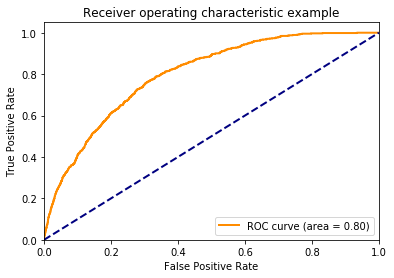

In [23]:
# training auc
# roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1])
plotROC(y_train, xgb_model.predict_proba(X_train)[:,1])

In [24]:
# test auc
y_pred = xgb_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.71113438152651

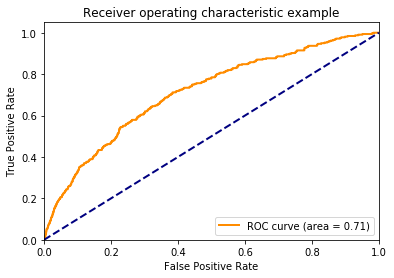

In [25]:
plotROC(y_test, y_pred)

In [26]:
# confusion matrix
y_pred_class = xgb_model.predict(X_test)
confusion_matrix(y_test, y_pred_class)

array([[30793, 12452],
       [  126,   190]])

In [27]:
# train with all data
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42, 
                              eval_metric="auc",
                              learning_rate=0.05,
                              max_depth=4,
                              n_estimators=150, 
                              n_jobs=-1,
                              tree_method = 'auto',
                              scale_pos_weight=136)  # sum(y == 0) / sum(y == 1)

xgb_model.fit(X, y, verbose=1)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=136, seed=None,
              silent=None, subsample=1, tree_method='auto', verbosity=1)

In [28]:
# train auc
y_pred = xgb_model.predict_proba(X)[:,1]
roc_auc_score(y, y_pred)

0.8234856135641998

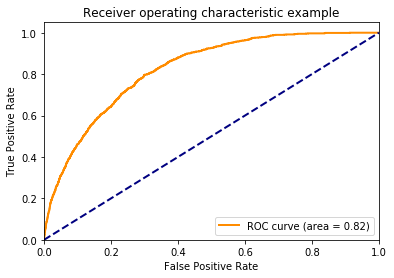

In [29]:
plotROC(y, y_pred)

In [30]:
# pridict[线上，0.774493]
result = pd.DataFrame()
result['id'] = ids
result['target'] = xgb_model.predict_proba(testX)[:,1]

result.to_csv('../submissions/xgb.csv', index=None)

## Easy Ensemble Classifier[0.76]

In [31]:
eec = EasyEnsembleClassifier(random_state=0,
                            n_estimators=150,
                            n_jobs=-1,
                            warm_start=True,
                            verbose=1)
eec.fit(X_train, y_train)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.6min finished


EasyEnsembleClassifier(base_estimator=None, n_estimators=150, n_jobs=-1,
                       random_state=0, replacement=False,
                       sampling_strategy='auto', verbose=1, warm_start=True)

In [32]:
y_pred_class = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred_class)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min finished


0.6664755272798055

In [33]:
confusion_matrix(y_test, y_pred_class)

array([[28631, 14614],
       [  104,   212]])

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min finished


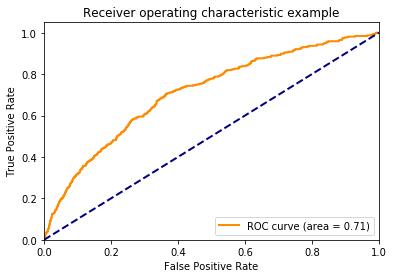

In [34]:
y_pred = eec.predict_proba(X_test)[:, 1]
plotROC(y_test, y_pred)

In [35]:
# fit all data
eec = EasyEnsembleClassifier(random_state=0,
                            n_estimators=150,
                            n_jobs=-1,
                            warm_start=True,
                            verbose=1)
eec.fit(X, y)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.5min finished


EasyEnsembleClassifier(base_estimator=None, n_estimators=150, n_jobs=2,
                       random_state=0, replacement=False,
                       sampling_strategy='auto', verbose=1, warm_start=True)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  5.7min finished


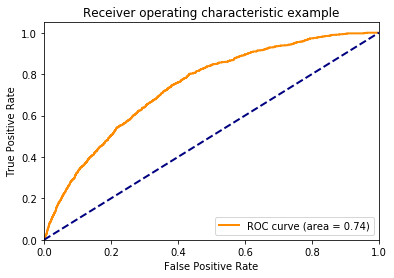

In [36]:
y_pred = eec.predict_proba(X)[:, 1]
plotROC(y, y_pred)

In [37]:
roc_auc_score(y, y_pred)

0.740596452698646

In [38]:
# pridict
result = pd.DataFrame()
result['id'] = ids
result['target'] = eec.predict_proba(testX)[:, 1]
result.to_csv('../submissions/EasyEnsemble.csv', index=None)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   59.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   59.0s finished


## Balanced Bagging Classifier

In [48]:
bc = BalancedBaggingClassifier(base_estimator=AdaBoostClassifier(),
                              random_state=42,
                              n_estimators=50,
                              n_jobs=2,
                              verbose=1)
bc.fit(X_train, y_train)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   26.8s finished


BalancedBaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                            base_estimator=None,
                                                            learning_rate=1.0,
                                                            n_estimators=50,
                                                            random_state=None),
                          bootstrap=True, bootstrap_features=False,
                          max_features=1.0, max_samples=1.0, n_estimators=50,
                          n_jobs=2, oob_score=False, random_state=42,
                          ratio=None, replacement=False,
                          sampling_strategy='auto', verbose=1,
                          warm_start=False)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.3min finished


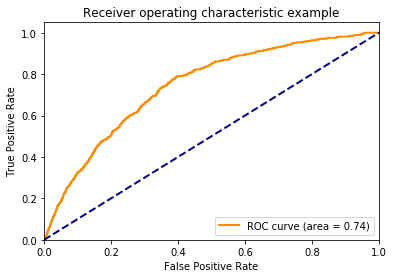

In [49]:
# training data
plotROC(y_train, bc.predict_proba(X_train)[:,1])

In [50]:
confusion_matrix(y_train, bc.predict(X_train))

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.3min finished


array([[62048, 25749],
       [  225,   418]])

In [51]:
# test data
y_pred_class = bc.predict(X_test)
# balanced_accuracy_score(y_test, y_pred_class)
confusion_matrix(y_test, y_pred_class)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   41.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   41.2s finished


array([[30346, 12899],
       [  119,   197]])

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.0s finished


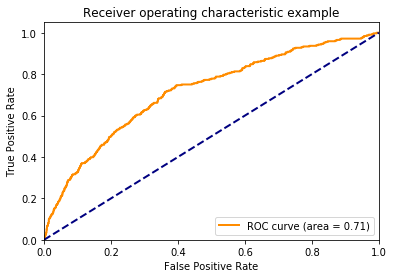

In [52]:
y_pred = bc.predict_proba(X_test)[:, 1]
plotROC(y_test, y_pred)

In [53]:
# fit all data
bc = BalancedBaggingClassifier(base_estimator=AdaBoostClassifier(),
                              random_state=0,
                              n_estimators=100,
                              n_jobs=2,
                              verbose=1)
bc.fit(X, y)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.3min finished


BalancedBaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                            base_estimator=None,
                                                            learning_rate=1.0,
                                                            n_estimators=50,
                                                            random_state=None),
                          bootstrap=True, bootstrap_features=False,
                          max_features=1.0, max_samples=1.0, n_estimators=100,
                          n_jobs=2, oob_score=False, random_state=0, ratio=None,
                          replacement=False, sampling_strategy='auto',
                          verbose=1, warm_start=False)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.7min finished


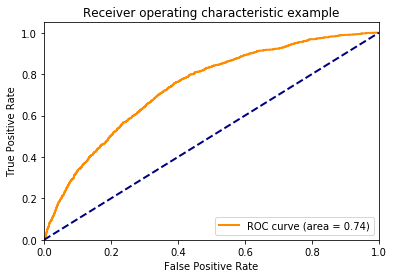

In [54]:
y_pred = bc.predict_proba(X)[:, 1]
plotROC(y, y_pred)

In [55]:
roc_auc_score(y, y_pred)

0.7387508027220464

In [56]:
result = pd.DataFrame()
result['id'] = ids
result['target'] = bc.predict_proba(testX)[:, 1]
result.to_csv('../submissions/BalancedBaggingClassifier.csv', index=None)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.7s finished


In [63]:
result = pd.DataFrame()
result['id'] = ids
result['target'] = rusboost.predict_proba(testX)[:, 1]
result.to_csv('../submissions/RUSBoostClassifier[test].csv', index=None)